In [1]:
# correlation plot: 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


In [2]:
df_all = pd.read_csv("NHIP_10categories_promoter_genebody_means.csv")
df_all

,x_label,sample,group,promoter_mean,genebody_mean
0,brain:Hypothalamus,46505-Hypothalamus,Obese,0.005952,0.752894
1,brain:Hypothalamus,46658-Hypothalamus,Control,0.102381,0.766342
2,brain:Hypothalamus,46668-Hypothalamus,Control,0.000000,0.746836
3,brain:Hypothalamus,46671-Hypothalamus,Obese,0.002646,0.760396
4,brain:Hypothalamus,46742-Hypothalamus,Control,0.023339,0.743621
...,...,...,...,...,...
278,oocytes:ROI,4660644938SO2NC1N9C,Control,NaN,0.800000
279,oocytes:ROI,4660644938SO3NC1O9C,Control,NaN,0.736842
280,oocytes:ROI,4660644993PO2NC5D10C,Control,NaN,0.696429
281,oocytes:ROI,4660644993PO3NC5E10C,Control,NaN,0.820513


In [8]:

# ---------- tissue color map ----------
TISSUE_COLORS = {
    "brain":   "#4C72B0",
    "cfDNA":   "#DD8452",
    "nasal":   "#55A868",
    "cumulus": "#C44E52",
    "oocytes": "#8172B3",
}

def tissue_from_category(cat: str) -> str:
    if cat.startswith("brain:"):   return "brain"
    if cat.startswith("cfDNA:"):   return "cfDNA"
    if cat.startswith("nasal:"):   return "nasal"
    if cat.startswith("cumulus:"): return "cumulus"
    if cat.startswith("oocytes:"): return "oocytes"
    return "other"

In [9]:

def collapse_to_control_condition(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create grp2: Control vs Condition.
    Assumes df has 'group' with values like Control/Obese/Stress/Exposed, etc.
    """
    out = df.copy()
    out["grp2"] = np.where(out["group"].isin(["Control", "C"]), "Control", "Condition")
    out["tissue"] = out["x_label"].apply(tissue_from_category)
    return out

def plot_corr(df: pd.DataFrame, grp2_value: str, out_png: str, title: str):
    d = df[(df["grp2"] == grp2_value)].copy()
    d = d.dropna(subset=["promoter_mean", "genebody_mean", "tissue"])

    if d.empty:
        print(f"No data for {grp2_value}")
        return

    x = d["promoter_mean"].values
    y = d["genebody_mean"].values

    # correlations
    r_p, p_p = pearsonr(x, y)
    r_s, p_s = spearmanr(x, y)

    # regression line (least squares)
    m, b = np.polyfit(x, y, 1)
    xx = np.linspace(np.nanmin(x), np.nanmax(x), 200)
    yy = m * xx + b

    fig, ax = plt.subplots(figsize=(7.5, 6.5))

    # scatter by tissue
    for tissue, sub in d.groupby("tissue"):
        ax.scatter(
            sub["promoter_mean"], sub["genebody_mean"],
            s=55, alpha=0.9,
            color=TISSUE_COLORS.get(tissue, "gray"),
            edgecolor="black", linewidth=0.5,
            label=tissue
        )

    # regression line
    ax.plot(xx, yy, linewidth=2, color="black", alpha=0.8)

    # labels/titles
    ax.set_xlabel("CpG island mean methylation (promoter)", fontsize=13, fontweight="bold")
    ax.set_ylabel("Gene body mean methylation", fontsize=13, fontweight="bold")
    ax.set_title(title, fontsize=14, fontweight="bold", pad=10)

    # stats text
    ax.text(
        0.02, 0.98,
        f"Pearson r = {r_p:.2f} (p={p_p:.2g})\nSpearman ρ = {r_s:.2f} (p={p_s:.2g})\nN = {len(d)}",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=11, fontweight="bold"
    )

    # cosmetics
    ax.set_xlim(0, 1.02)
    ax.set_ylim(0, 1.02)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(title="Tissue", frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)


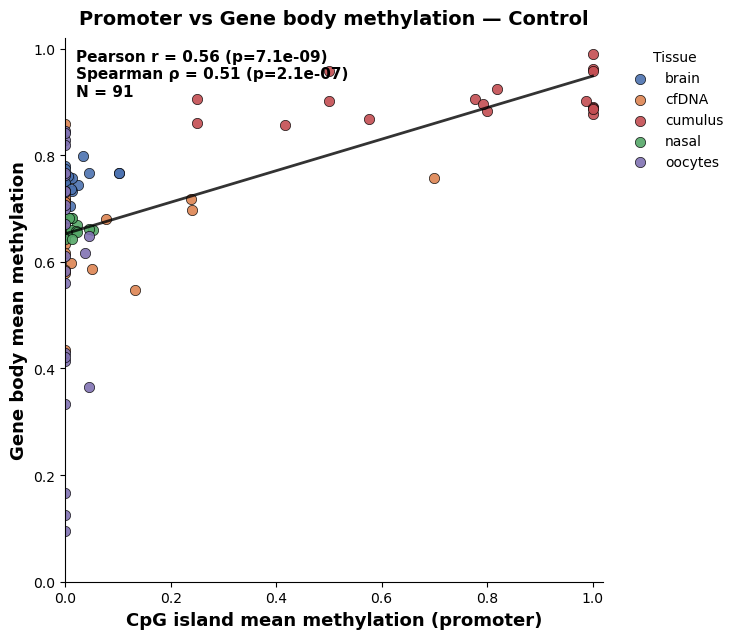

Saved: NHIP_corr_promoter_vs_genebody_Control.pdf


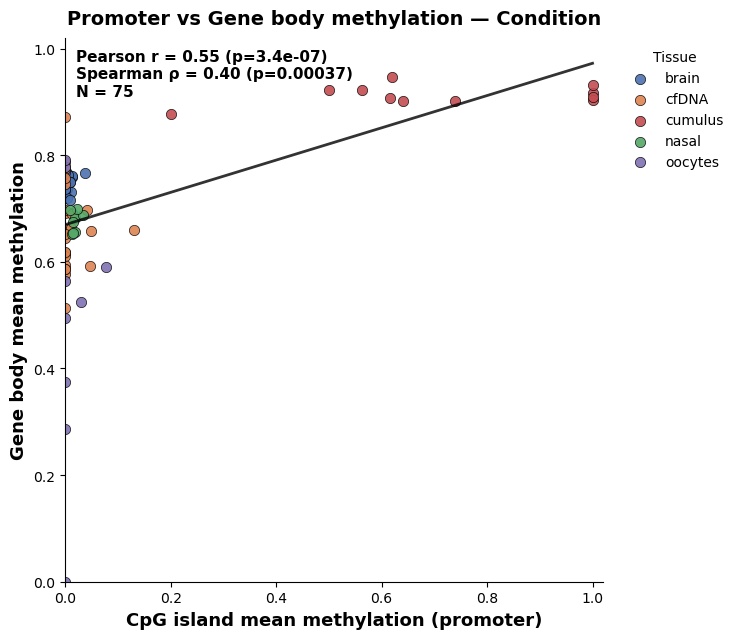

Saved: NHIP_corr_promoter_vs_genebody_Condition.pdf


In [10]:

# ------------------ RUN ------------------
# df_all must already exist OR load it:
# df_all = pd.read_csv("NHIP_10categories_promoter_genebody_means.csv")

dfp = collapse_to_control_condition(df_all)

plot_corr(
    dfp,
    grp2_value="Control",
    out_png="NHIP_corr_promoter_vs_genebody_Control.pdf",
    title="Promoter vs Gene body methylation — Control"
)

plot_corr(
    dfp,
    grp2_value="Condition",
    out_png="NHIP_corr_promoter_vs_genebody_Condition.pdf",
    title="Promoter vs Gene body methylation — Condition"
)


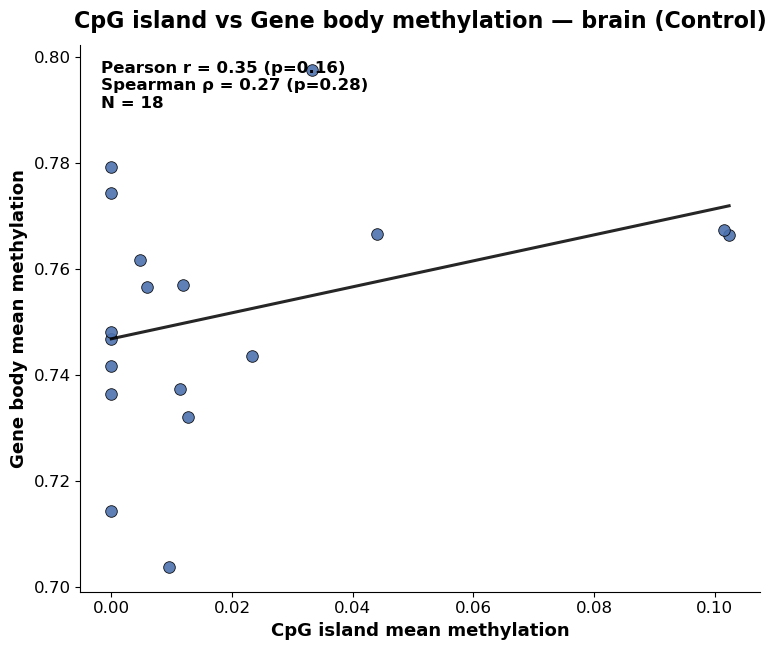

Saved: NHIP_corr_brain_Control.pdf


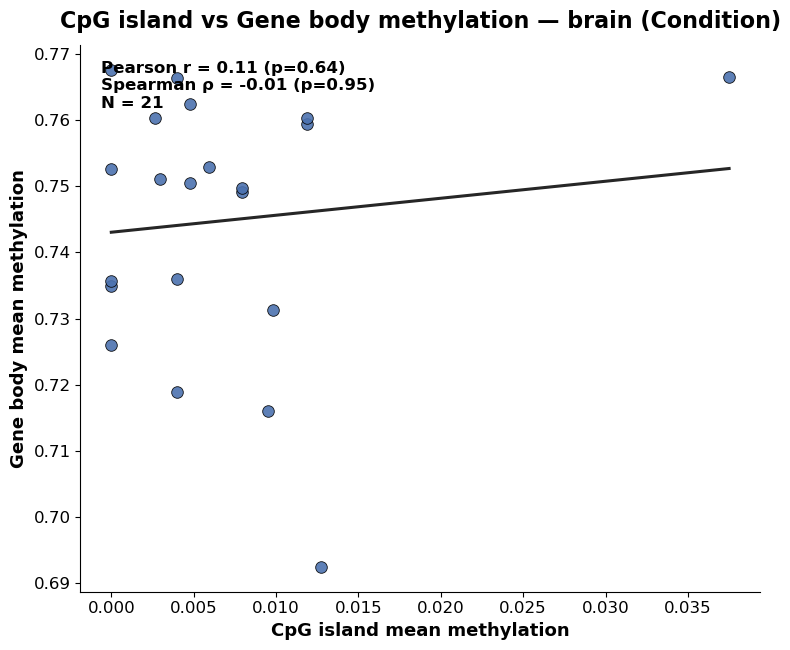

Saved: NHIP_corr_brain_Condition.pdf


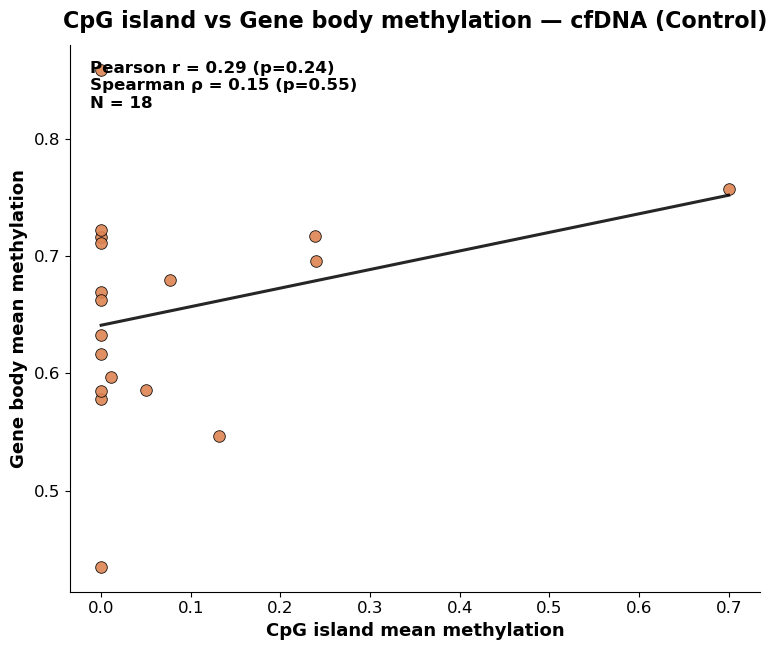

Saved: NHIP_corr_cfDNA_Control.pdf


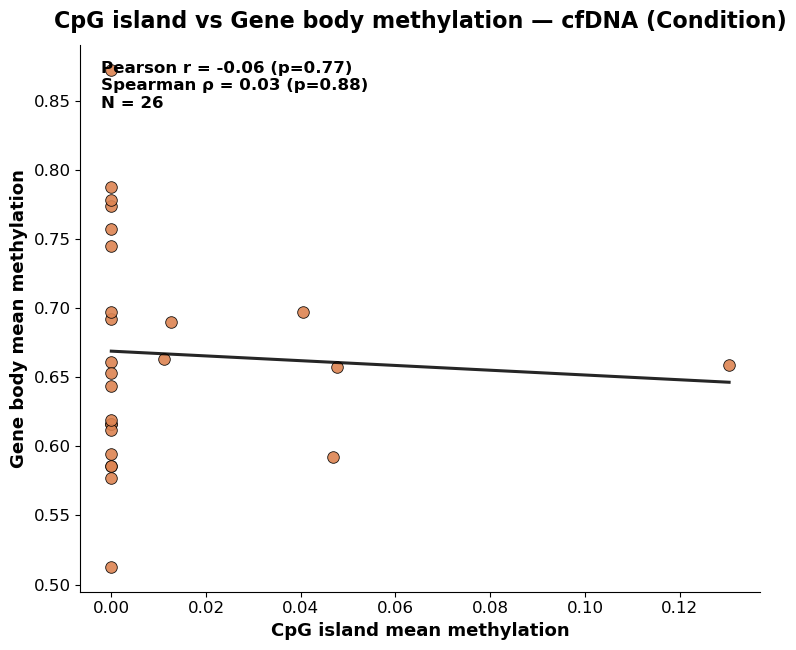

Saved: NHIP_corr_cfDNA_Condition.pdf


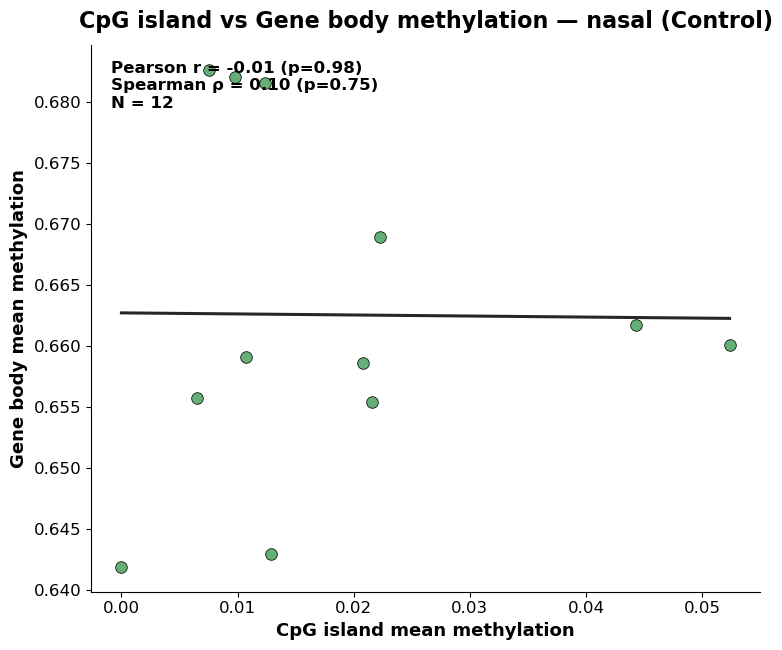

Saved: NHIP_corr_nasal_Control.pdf


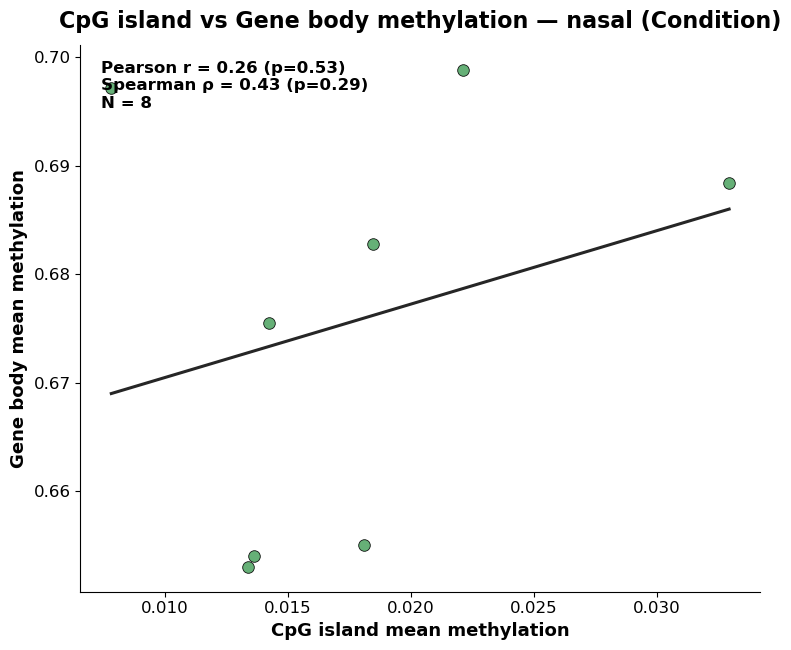

Saved: NHIP_corr_nasal_Condition.pdf


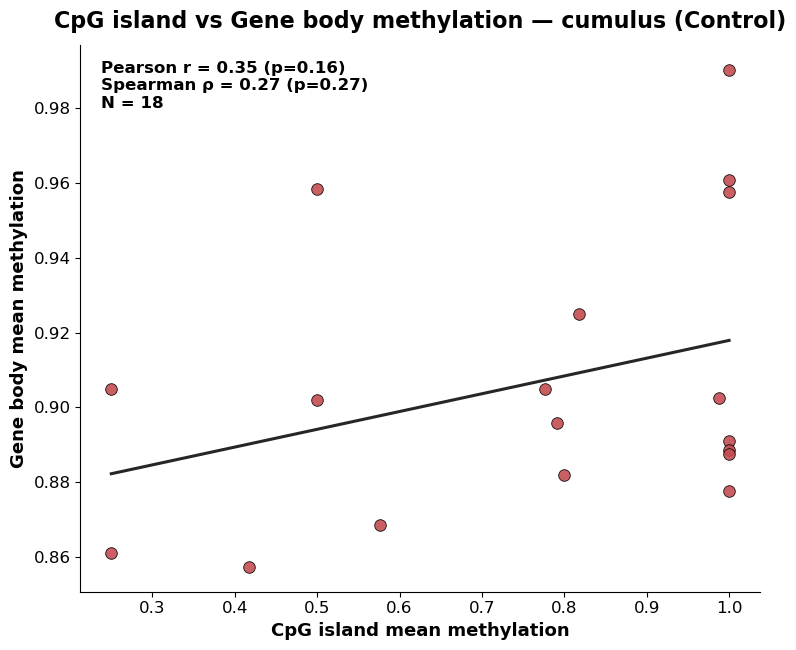

Saved: NHIP_corr_cumulus_Control.pdf


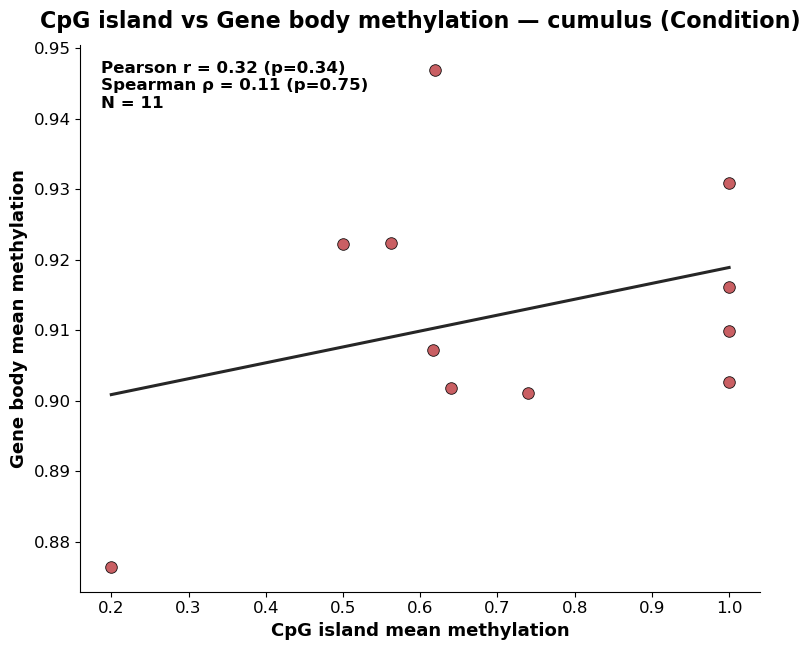

Saved: NHIP_corr_cumulus_Condition.pdf


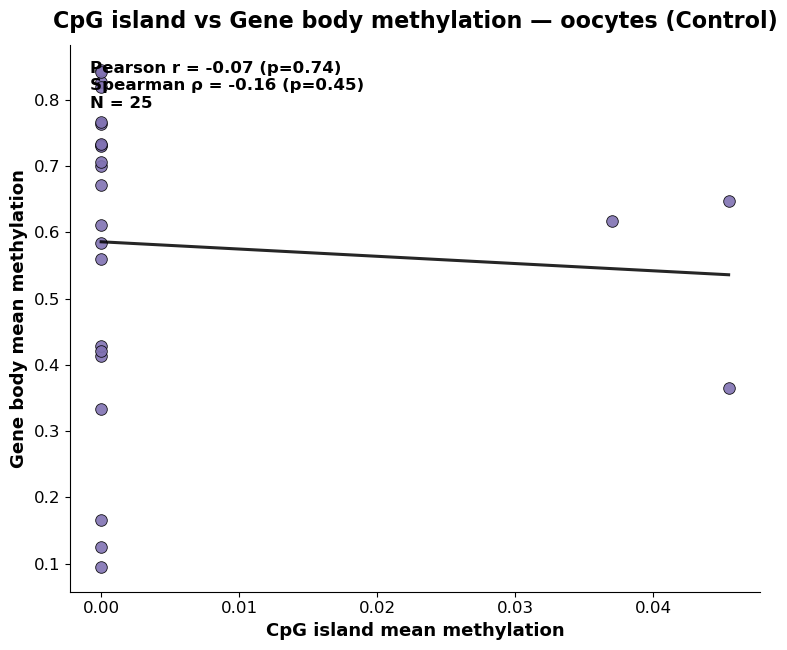

Saved: NHIP_corr_oocytes_Control.pdf


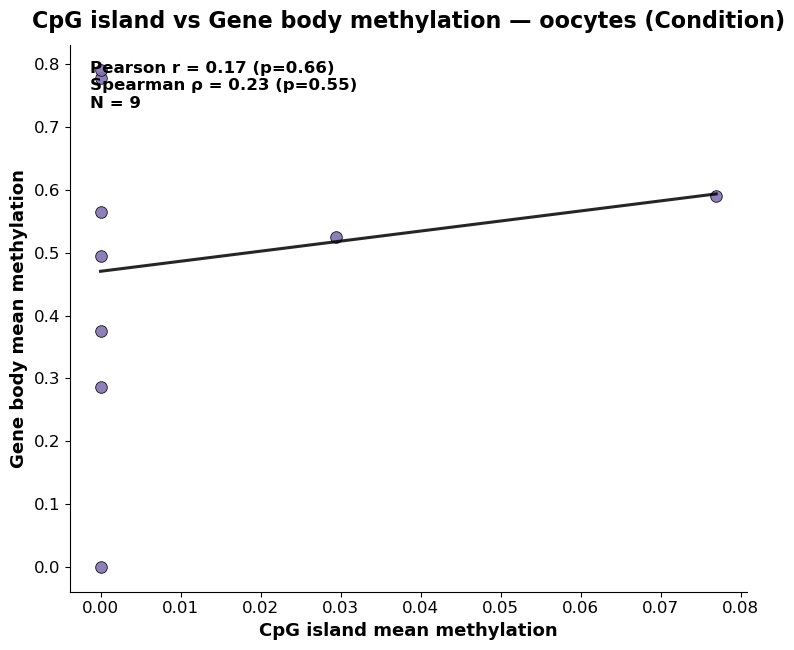

Saved: NHIP_corr_oocytes_Condition.pdf


In [11]:
# ============================================================
# NHIP: Correlation plots (CpG island vs Gene body methylation)
#   - Make separate plots for each tissue type:
#       brain, cfDNA, nasal, cumulus, oocytes
#   - For each tissue: 2 plots (Control vs Condition)
#   - Total plots = 10
#   - No fixed xlim/ylim (autoscale)
#   - Uses "CpG island" wording (NOT promoter)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from matplotlib.patches import Patch

# -------------------- Tissue colors --------------------
TISSUE_COLORS = {
    "brain":   "#4C72B0",
    "cfDNA":   "#DD8452",
    "nasal":   "#55A868",
    "cumulus": "#C44E52",
    "oocytes": "#8172B3",
}

TISSUES_TO_PLOT = ["brain", "cfDNA", "nasal", "cumulus", "oocytes"]

# -------------------- Helpers --------------------
def tissue_from_category(cat: str) -> str:
    if cat.startswith("brain:"):   return "brain"
    if cat.startswith("cfDNA:"):   return "cfDNA"
    if cat.startswith("nasal:"):   return "nasal"
    if cat.startswith("cumulus:"): return "cumulus"
    if cat.startswith("oocytes:"): return "oocytes"
    return "other"

def add_grp2_and_tissue(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds:
      - grp2: Control vs Condition
      - tissue: brain/cfDNA/nasal/cumulus/oocytes
    Requires df has: group, x_label, promoter_mean, genebody_mean
    (we will label promoter_mean as CpG island mean methylation in plots)
    """
    out = df.copy()
    out["grp2"] = np.where(out["group"].isin(["Control", "C"]), "Control", "Condition")
    out["tissue"] = out["x_label"].astype(str).apply(tissue_from_category)
    return out

def safe_corr(x, y, method="pearson"):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    ok = (~np.isnan(x)) & (~np.isnan(y))
    x = x[ok]
    y = y[ok]
    if len(x) < 3:
        return np.nan, np.nan, len(x)
    if method == "spearman":
        r, p = spearmanr(x, y)
    else:
        r, p = pearsonr(x, y)
    return r, p, len(x)

def plot_corr_tissue(
    df: pd.DataFrame,
    tissue: str,
    grp2_value: str,
    out_png: str,
    title: str,
    annotate_points=False,
):
    d = df[(df["tissue"] == tissue) & (df["grp2"] == grp2_value)].copy()
    d = d.dropna(subset=["promoter_mean", "genebody_mean"])

    if d.empty:
        print(f"No data for {tissue} — {grp2_value}")
        return

    x = d["promoter_mean"].values
    y = d["genebody_mean"].values

    r_p, p_p, n = safe_corr(x, y, method="pearson")
    r_s, p_s, _ = safe_corr(x, y, method="spearman")

    # Regression line if enough points
    ok = (~np.isnan(x)) & (~np.isnan(y))
    x_ok = x[ok]
    y_ok = y[ok]
    do_line = len(x_ok) >= 3
    if do_line:
        m, b = np.polyfit(x_ok, y_ok, 1)
        xx = np.linspace(np.min(x_ok), np.max(x_ok), 200)
        yy = m * xx + b

    fig, ax = plt.subplots(figsize=(7.8, 6.6))

    ax.scatter(
        x, y,
        s=70, alpha=0.9,
        color=TISSUE_COLORS.get(tissue, "gray"),
        edgecolor="black", linewidth=0.6,
    )

    if annotate_points:
        # label by x_label/sample if you want (optional)
        for _, row in d.iterrows():
            ax.text(row["promoter_mean"], row["genebody_mean"], str(row.get("sample","")),
                    fontsize=8, alpha=0.7)

    if do_line:
        ax.plot(xx, yy, linewidth=2.2, color="black", alpha=0.85)

    ax.set_xlabel("CpG island mean methylation", fontsize=13, fontweight="bold")
    ax.set_ylabel("Gene body mean methylation", fontsize=13, fontweight="bold")
    ax.set_title(title, fontsize=16, fontweight="bold", pad=12)

    stat_txt = (
        f"Pearson r = {r_p:.2f} (p={p_p:.2g})\n"
        f"Spearman ρ = {r_s:.2f} (p={p_s:.2g})\n"
        f"N = {n}"
    )
    ax.text(
        0.03, 0.97,
        stat_txt,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12, fontweight="bold"
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", labelsize=12)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)

# -------------------- MAIN --------------------
def main():
    # df_all must exist OR load it:
    # df_all = pd.read_csv("NHIP_10categories_promoter_genebody_means.csv")
    global df_all
    if "df_all" not in globals():
        raise NameError("df_all is not defined. Load it: df_all = pd.read_csv('NHIP_10categories_promoter_genebody_means.csv')")

    df = add_grp2_and_tissue(df_all)

    for tissue in TISSUES_TO_PLOT:
        for grp2_value in ["Control", "Condition"]:
            out_png = f"NHIP_corr_{tissue}_{grp2_value}.pdf"
            title = f"CpG island vs Gene body methylation — {tissue} ({grp2_value})"
            plot_corr_tissue(
                df,
                tissue=tissue,
                grp2_value=grp2_value,
                out_png=out_png,
                title=title
            )

if __name__ == "__main__":
    main()


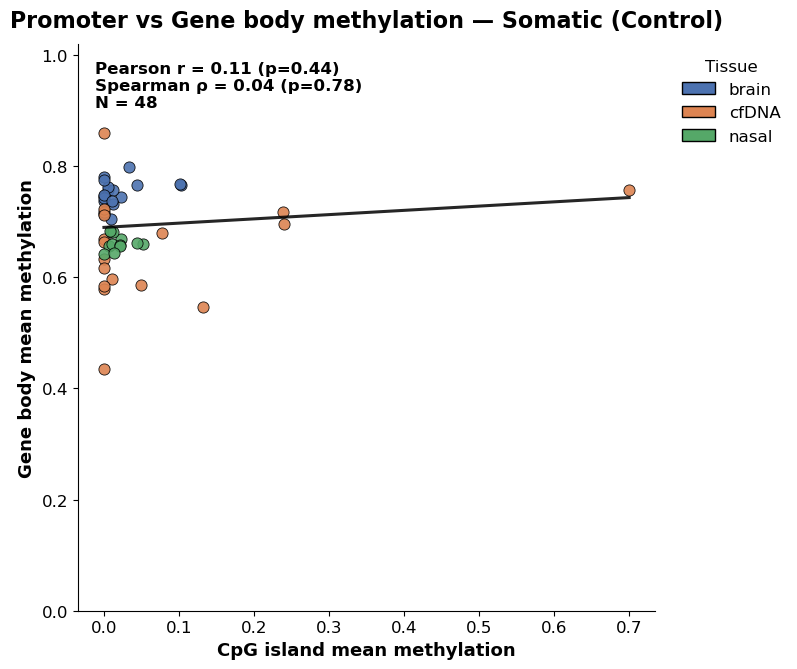

Saved: NHIP_corr_Somatic_Control.pdf


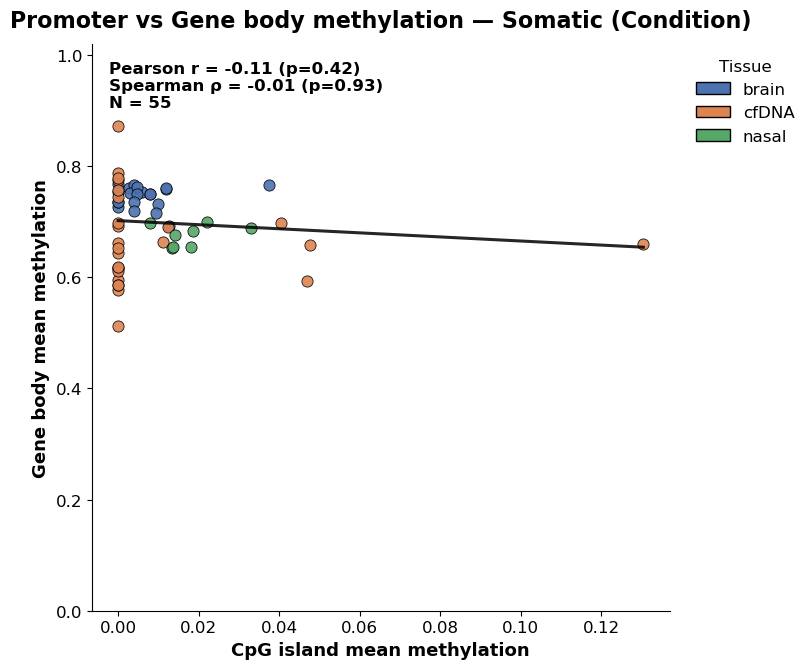

Saved: NHIP_corr_Somatic_Condition.pdf


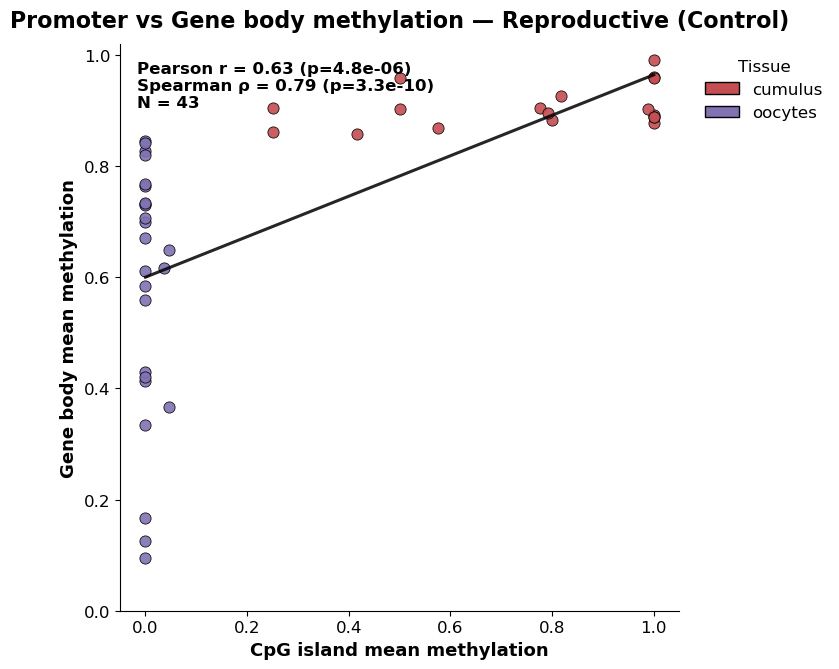

Saved: NHIP_corr_Reproductive_Control.pdf


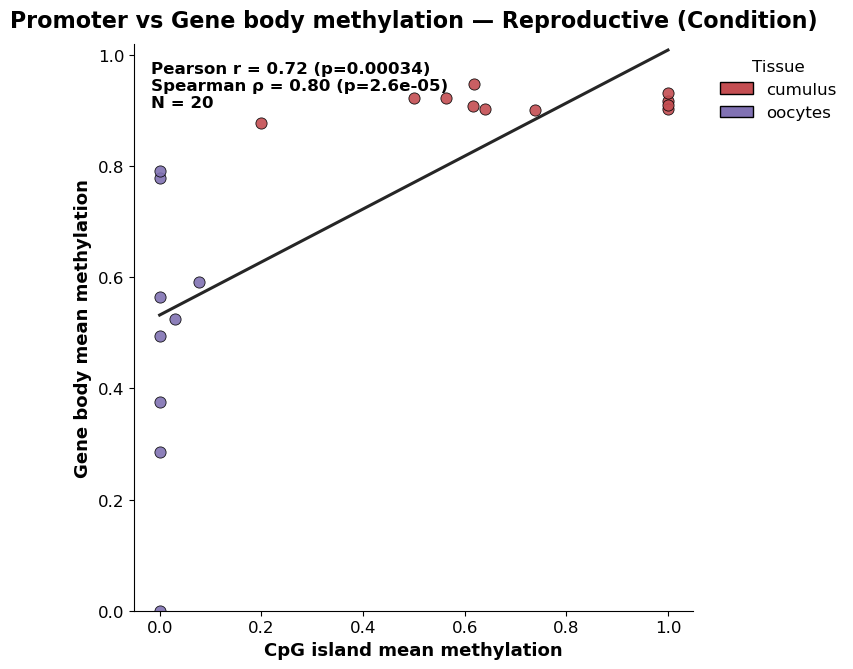

Saved: NHIP_corr_Reproductive_Condition.pdf


In [13]:
# ============================================================
# NHIP: Correlation plots (Promoter CpG island vs Gene body)
#   - Split into SOMATIC vs REPRODUCTIVE tissue classes
#   - Make 4 plots total:
#       1) Somatic — Control
#       2) Somatic — Condition
#       3) Reproductive — Control
#       4) Reproductive — Condition
#   - Points colored by tissue type
#   - Reports Pearson r and Spearman ρ + p-values, with regression line
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from matplotlib.patches import Patch

# -------------------- Colors by tissue --------------------
TISSUE_COLORS = {
    "brain":   "#4C72B0",
    "cfDNA":   "#DD8452",
    "nasal":   "#55A868",
    "cumulus": "#C44E52",
    "oocytes": "#8172B3",
}

# Tissue classes
SOMATIC_TISSUES = {"brain", "nasal", "cfDNA"}
REPRO_TISSUES   = {"cumulus", "oocytes"}

# -------------------- Helpers --------------------
def tissue_from_category(cat: str) -> str:
    if cat.startswith("brain:"):   return "brain"
    if cat.startswith("cfDNA:"):   return "cfDNA"
    if cat.startswith("nasal:"):   return "nasal"
    if cat.startswith("cumulus:"): return "cumulus"
    if cat.startswith("oocytes:"): return "oocytes"
    return "other"

def add_grp2_and_tissue(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds:
      - grp2: Control vs Condition
      - tissue: brain/cfDNA/nasal/cumulus/oocytes
      - class: Somatic vs Reproductive (based on tissue)
    Requires df has: group, x_label, promoter_mean, genebody_mean
    """
    out = df.copy()

    # Collapse multiple condition labels into Control vs Condition
    out["grp2"] = np.where(out["group"].isin(["Control", "C"]), "Control", "Condition")

    # Tissue from x_label
    out["tissue"] = out["x_label"].astype(str).apply(tissue_from_category)

    # Tissue class
    out["class"] = np.where(out["tissue"].isin(SOMATIC_TISSUES), "Somatic",
                    np.where(out["tissue"].isin(REPRO_TISSUES), "Reproductive", "Other"))
    return out

def safe_corr(x, y, method="pearson"):
    """Returns (r, p). Handles too-small N gracefully."""
    x = np.asarray(x)
    y = np.asarray(y)
    ok = (~np.isnan(x)) & (~np.isnan(y))
    x = x[ok]
    y = y[ok]
    if len(x) < 3:
        return np.nan, np.nan
    if method == "spearman":
        r, p = spearmanr(x, y)
    else:
        r, p = pearsonr(x, y)
    return r, p

def plot_corr_subset(
    df: pd.DataFrame,
    grp2_value: str,
    class_value: str,
    out_png: str,
    title: str,
):
    d = df[(df["grp2"] == grp2_value) & (df["class"] == class_value)].copy()
    d = d.dropna(subset=["promoter_mean", "genebody_mean", "tissue"])

    if d.empty:
        print(f"No data for {class_value} — {grp2_value}")
        return

    x = d["promoter_mean"].values
    y = d["genebody_mean"].values

    # Correlations
    r_p, p_p = safe_corr(x, y, method="pearson")
    r_s, p_s = safe_corr(x, y, method="spearman")

    # Regression line (only if enough points)
    ok = (~np.isnan(x)) & (~np.isnan(y))
    x_ok = x[ok]
    y_ok = y[ok]
    do_line = len(x_ok) >= 3
    if do_line:
        m, b = np.polyfit(x_ok, y_ok, 1)
        xx = np.linspace(np.min(x_ok), np.max(x_ok), 200)
        yy = m * xx + b

    fig, ax = plt.subplots(figsize=(8, 6.8))

    # Scatter by tissue
    for tissue, sub in d.groupby("tissue"):
        ax.scatter(
            sub["promoter_mean"], sub["genebody_mean"],
            s=65, alpha=0.9,
            color=TISSUE_COLORS.get(tissue, "gray"),
            edgecolor="black", linewidth=0.6,
            label=tissue
        )

    # Regression line
    if do_line:
        ax.plot(xx, yy, linewidth=2.2, color="black", alpha=0.85)

    # Labels and title
    ax.set_xlabel("CpG island mean methylation", fontsize=13, fontweight="bold")
    ax.set_ylabel("Gene body mean methylation", fontsize=13, fontweight="bold")
    ax.set_title(title, fontsize=16, fontweight="bold", pad=12)

    # Stats text
    stat_txt = (
        f"Pearson r = {r_p:.2f} (p={p_p:.2g})\n"
        f"Spearman ρ = {r_s:.2f} (p={p_s:.2g})\n"
        f"N = {len(d)}"
    )
    ax.text(
        0.03, 0.97,
        stat_txt,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12, fontweight="bold"
    )

    # Cosmetics
    #ax.set_xlim(0, 1.02)
    ax.set_ylim(0, 1.02)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", labelsize=12)

    # Legend: only show tissues present in this subset
    present = list(d["tissue"].unique())
    legend_elements = [
        Patch(facecolor=TISSUE_COLORS[t], edgecolor="black", label=t)
        for t in present if t in TISSUE_COLORS
    ]
    ax.legend(
        handles=legend_elements,
        title="Tissue",
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        fontsize=12,
        title_fontsize=12
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)


# -------------------- MAIN --------------------
def main():
    # df_all must exist in your notebook/session OR load from CSV:
    # df_all = pd.read_csv("NHIP_10categories_promoter_genebody_means.csv")

    global df_all
    if "df_all" not in globals():
        raise NameError("df_all is not defined. Load it first: df_all = pd.read_csv('NHIP_10categories_promoter_genebody_means.csv')")

    df = add_grp2_and_tissue(df_all)

    # 4 plots: Somatic vs Reproductive, Control vs Condition
    plot_corr_subset(
        df, grp2_value="Control", class_value="Somatic",
        out_png="NHIP_corr_Somatic_Control.pdf",
        title="Promoter vs Gene body methylation — Somatic (Control)"
    )
    plot_corr_subset(
        df, grp2_value="Condition", class_value="Somatic",
        out_png="NHIP_corr_Somatic_Condition.pdf",
        title="Promoter vs Gene body methylation — Somatic (Condition)"
    )
    plot_corr_subset(
        df, grp2_value="Control", class_value="Reproductive",
        out_png="NHIP_corr_Reproductive_Control.pdf",
        title="Promoter vs Gene body methylation — Reproductive (Control)"
    )
    plot_corr_subset(
        df, grp2_value="Condition", class_value="Reproductive",
        out_png="NHIP_corr_Reproductive_Condition.pdf",
        title="Promoter vs Gene body methylation — Reproductive (Condition)"
    )

if __name__ == "__main__":
    main()
